In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split
from sklearn.linear_model import RandomizedLasso,Ridge,Lasso,LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_train_data():
    X_train=pd.read_csv('train_features.csv')
    y=pd.read_csv('train_salaries.csv')
    x=X_train
    x.index,y.index=x['jobId'],y['jobId']
    x['salary']=y['salary']
    return x,x['salary']

In [3]:
#section 1: read train data
x,y=read_train_data()

# section 2: explore data (this does not need to run in final prediction)  

#read & preprocess training data, and select important features
#commented out because not used in the final model

In [4]:
x=x[x['salary']>0]
x.drop(['jobId'],axis=1,inplace=True)

In [5]:
def check_distribution(x,var):
    # check distribution of salary
    plt.figure(figsize=(15,8))
    plt.subplot(131)
    x[var].hist(bins=20)
    print('skewness',stats.skew(x[var]))
    plt.subplot(132)
    sns.distplot(x[var])
    plt.subplot(133)
    stats.probplot(x[var],plot=plt)

skewness 0.3465267592829531


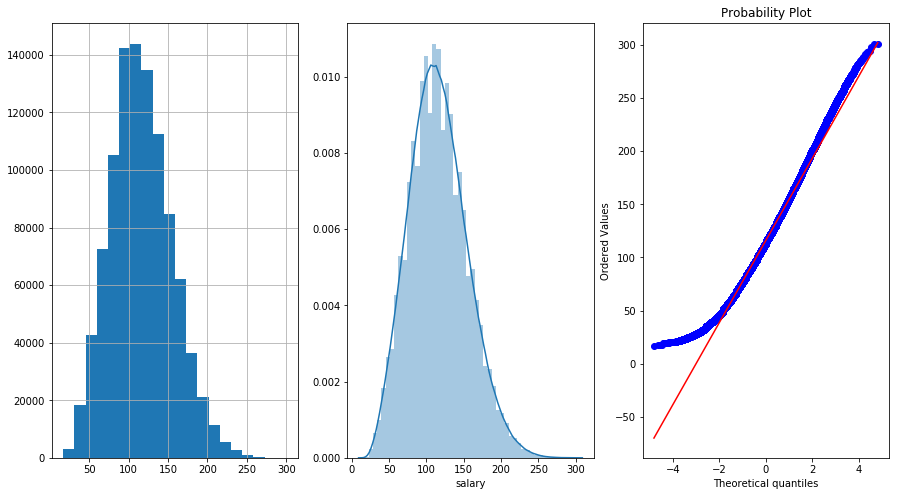

In [34]:
# check distribution of the numerical features and salary
check_distribution(x,'salary')

skewness -0.0011439091058045947
skewness 0.0016712466130474341


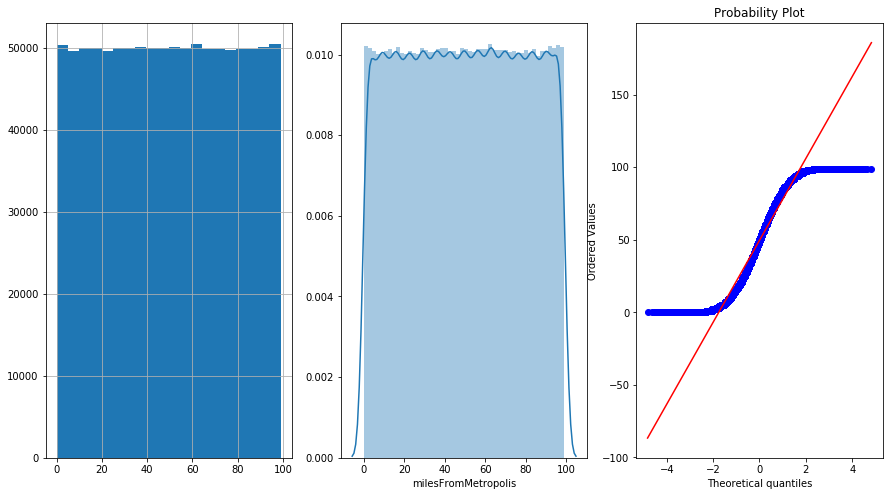

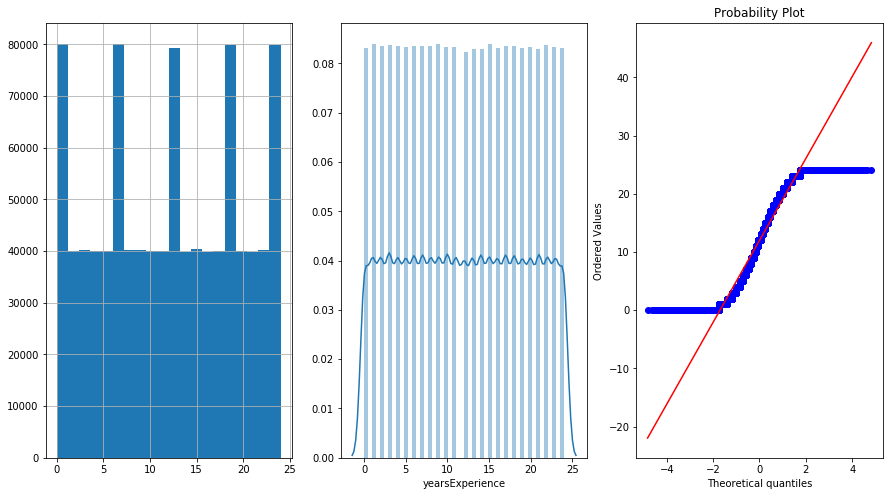

In [35]:
# check distribution of other numerical variables
check_distribution(x,'milesFromMetropolis')
check_distribution(x,'yearsExperience')

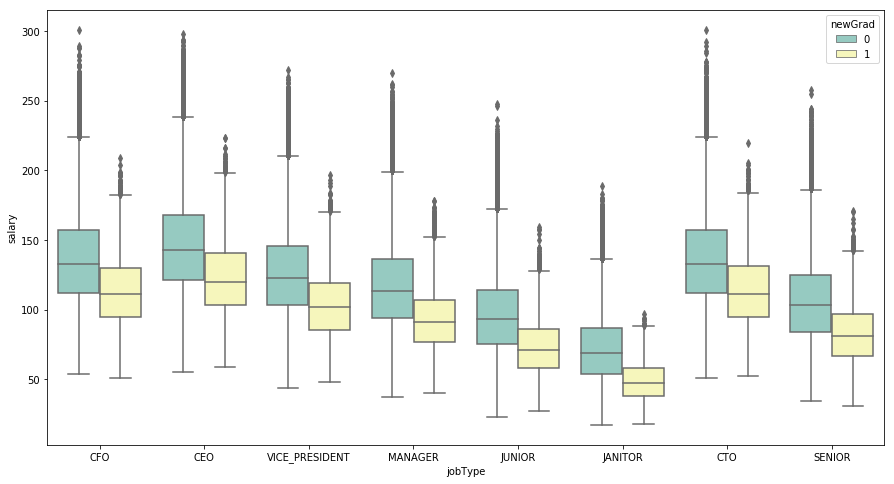

In [39]:
 # add a new feature 
x['newGrad']=x['yearsExperience'].apply(lambda x: 1 if x==1 else 0) 
plt.figure(figsize=(15,8))
g=sns.boxplot(x="jobType", y="salary", hue="newGrad", data=x, palette="Set3")

In [6]:
def convert_toDummy(x):
    # convert nominal/categorical data to numerical data
    vec = DictVectorizer(sparse=False, dtype=int)
    vec_x=vec.fit_transform(x.to_dict(orient = 'records'))
    names = vec.get_feature_names()
    df=pd.DataFrame(data=vec_x,columns=names)
    return df

In [7]:
# convert categorical/nominal features to numerical dummy features
df_train=convert_toDummy(x)

In [8]:
def feature_selection(Xnew,Y):
    train_cols = Xnew.columns.tolist()
    rlasso = RandomizedLasso(alpha=0.005)
    rlasso.fit(Xnew, Y)
    print("features sorted by their socre:")
    featureRanks = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),
                              train_cols), reverse=True)
    print(featureRanks)
    selectedFeats = [feat[1] for feat in featureRanks if feat[0] > 0.01]
    return selectedFeats,featureRanks

In [41]:
# feature selection
selectedFeats,featureRanks=feature_selection(df_train.drop('salary',axis=1),df_train['salary']) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


features sorted by their socre:
[(1.0, 'yearsExperience'), (1.0, 'milesFromMetropolis'), (1.0, 'jobType=JANITOR'), (0.73, 'major=NONE'), (0.61, 'jobType=CEO'), (0.505, 'industry=EDUCATION'), (0.5, 'industry=FINANCE'), (0.49, 'jobType=JUNIOR'), (0.48, 'industry=OIL'), (0.435, 'jobType=CFO'), (0.375, 'jobType=CTO'), (0.32, 'degree=DOCTORAL'), (0.3, 'jobType=SENIOR'), (0.215, 'degree=NONE'), (0.18, 'degree=HIGH_SCHOOL'), (0.07, 'industry=SERVICE'), (0.055, 'degree=MASTERS'), (0.0, 'newGrad'), (0.0, 'major=PHYSICS'), (0.0, 'major=MATH'), (0.0, 'major=LITERATURE'), (0.0, 'major=ENGINEERING'), (0.0, 'major=COMPSCI'), (0.0, 'major=CHEMISTRY'), (0.0, 'major=BUSINESS'), (0.0, 'major=BIOLOGY'), (0.0, 'jobType=VICE_PRESIDENT'), (0.0, 'jobType=MANAGER'), (0.0, 'industry=WEB'), (0.0, 'industry=HEALTH'), (0.0, 'industry=AUTO'), (0.0, 'degree=BACHELORS'), (0.0, 'companyId=COMP9'), (0.0, 'companyId=COMP8'), (0.0, 'companyId=COMP7'), (0.0, 'companyId=COMP62'), (0.0, 'companyId=COMP61'), (0.0, 'companyI

# section 3: preprocess training data 

In [21]:
def scale_x(data):
    #min-max scaling
    scaler=MinMaxScaler()
    scaler.fit(data)
    x=scaler.transform(data)
    return x
def preprocess_data(df):
    df_numerical=convert_toDummy(df)
    data_x=scale_x(df_numerical) # scale it
    cols=df_numerical.columns.values.tolist() 
    y=x['salary']
    return data_x,cols

In [23]:
selected_cols=['jobType','degree','industry','yearsExperience','milesFromMetropolis']
X,cols=preprocess_data(x[selected_cols])
y=x['salary'].values

# section 4: model selection and tuning (this does not need to run in final predction)

In [24]:
def evaluator(y_pred,y_test):
    print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

In [25]:
def train_model(data_x,data_y):
    # create training and testing sets
    X_train, X_test, y_train, y_test = \
    train_test_split(data_x,data_y, test_size=0.2, random_state=42)
    
    # model selection & tuning
    #print('linear regression')
    clf1 =LinearRegression()
    #print('ridge regression')
    clf2 = Ridge(alpha = .5)
    #print('lasso regression')
    clf3 = Lasso()
    
    #print('KNN')
    clf4 = KNeighborsRegressor()
    
    #print('Gradient boosting')
    clf5 = GradientBoostingRegressor(loss='huber', n_estimators=600, min_samples_split=10)
    
    #print('Random Forest')
    ranfModel = RandomForestRegressor()
    ranfPar = {'n_estimators':[10, 20, 500, 100], 'min_samples_split':[3,5,10,20]}
    clf6 = RandomizedSearchCV(ranfModel, ranfPar, verbose=10, n_iter=10)
    
    #print('decision tree regression')
    treeModel = DecisionTreeRegressor()
    treePar = {'splitter':['best', 'random'], 'max_depth':[3, 5, 10], 'min_samples_split':[3, 5, 10, 15, 20]}
    clf7 = RandomizedSearchCV(treeModel, treePar, verbose=10, n_iter=20)
    
    #clf10 = ExtraTreesRegressor()
    #clf6 = AdaBoostRegressor()
    
    clfs=[clf1,clf2,clf3,clf4,clf5,clf6,clf7]
    for clf in clfs:
        clf.fit(X_train, y_train)
        try:
            print("Best parameters set found on development set:")
            print(clf.best_params_)
        except:
            pass
        
        y_pred_train = clf.predict(X_train)
        print('evaluate training')    
        evaluator(y_train,y_pred_train)
        
        y_pred = clf.predict(X_test)
        print('evaluate testing')    
        evaluator(y_pred,y_test)
        
    return True

In [ ]:
train_model(X,y)

Best parameters set found on development set:
evaluate training
Root Mean squared error: 19.92
Variance score: 0.64
evaluate testing
Root Mean squared error: 19.88
Variance score: 0.74
Best parameters set found on development set:
evaluate training
Root Mean squared error: 19.92
Variance score: 0.64
evaluate testing
Root Mean squared error: 19.88
Variance score: 0.74


In [59]:
t=time.time()
regr = GradientBoostingRegressor(loss='huber', n_estimators=200, min_samples_split=10)

regr.fit(X_train, y_train)        
y_pred_train = regr.predict(X_train)
print('evaluate training')    
evaluator(y_train,y_pred_train)

y_pred = regr.predict(X_test)
print('evaluate testing')    
evaluator(y_pred,y_test)
print('time used:',time.time()-t)

evaluate training
Root Mean squared error: 19.49
Variance score: 0.65
evaluate testing
Root Mean squared error: 19.47
Variance score: 0.75
time used: 287.3290522098541


In [60]:
#final model
import time
t=time.time()
X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.2, random_state=42)

regr = RandomForestRegressor(n_estimators=100,min_samples_split=35)
regr.fit(X_train, y_train)        
y_pred_train = regr.predict(X_train)
print('evaluate training')    
evaluator(y_train,y_pred_train)

y_pred = regr.predict(X_test)
print('evaluate testing')    
evaluator(y_pred,y_test)
print('time used:',time.time()-t)

evaluate training
Root Mean squared error: 18.14
Variance score: 0.71
evaluate testing
Root Mean squared error: 19.81
Variance score: 0.74
time used: 320.85698342323303


In [61]:
#final model
import time
t=time.time()
X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.2, random_state=42)

regr = RandomForestRegressor(n_estimators=100,min_samples_split=35)
regr.fit(X_train, y_train)        
y_pred_train = regr.predict(X_train)
print('evaluate training')    
evaluator(y_train,y_pred_train)

y_pred = regr.predict(X_test)
print('evaluate testing')    
evaluator(y_pred,y_test)
print('time used:',time.time()-t)

evaluate training
Root Mean squared error: 18.14
Variance score: 0.71
evaluate testing
Root Mean squared error: 19.81
Variance score: 0.74
time used: 319.55183386802673


In [30]:
# cross_validation
t=time.time()
scores = cross_val_score(regr, X_train, y_train, cv=10,verbose=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('time used:',time.time()-t)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=0.7379310741437775, total= 4.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


[CV] ....................... , score=0.7378976498941725, total= 4.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.2min remaining:    0.0s


[CV] ....................... , score=0.7384900337089847, total= 4.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.8min remaining:    0.0s


[CV] ....................... , score=0.7387011686116776, total= 4.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.3min remaining:    0.0s


[CV] ....................... , score=0.7374687143982221, total= 4.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.9min remaining:    0.0s


[CV] ....................... , score=0.7364498711289286, total= 4.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.6min remaining:    0.0s


[CV] ....................... , score=0.7350740986183959, total= 4.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 32.1min remaining:    0.0s


[CV] ....................... , score=0.7393311091511461, total= 4.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 36.8min remaining:    0.0s


[CV] ....................... , score=0.7351713031573343, total= 4.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 41.5min remaining:    0.0s


[CV] ....................... , score=0.7418902913185401, total= 4.6min
Accuracy: 0.74 (+/- 0.00)
time used: 2768.8009371757507


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 46.1min finished


In [31]:
def plot_feature_importance(regr,cols):
    importances = regr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in regr.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    return True

In [44]:
X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.2, random_state=42)

In [45]:
# new method: XGBOOST
t=time.time()
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=np.array(cols))
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)
print('time used:',time.time()-t)

[18:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[18:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[18:22:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[18:22:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[18:22:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[18:22:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[18:22:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

In [58]:
t=time.time()
dtest = xgb.DMatrix(X_test ,feature_names=np.array(cols))
ypred = model.predict(dtest)
evaluator(y_pred,y_test)
print('time used:',time.time()-t)

Root Mean squared error: 19.81
Variance score: 0.74
time used: 0.19010281562805176


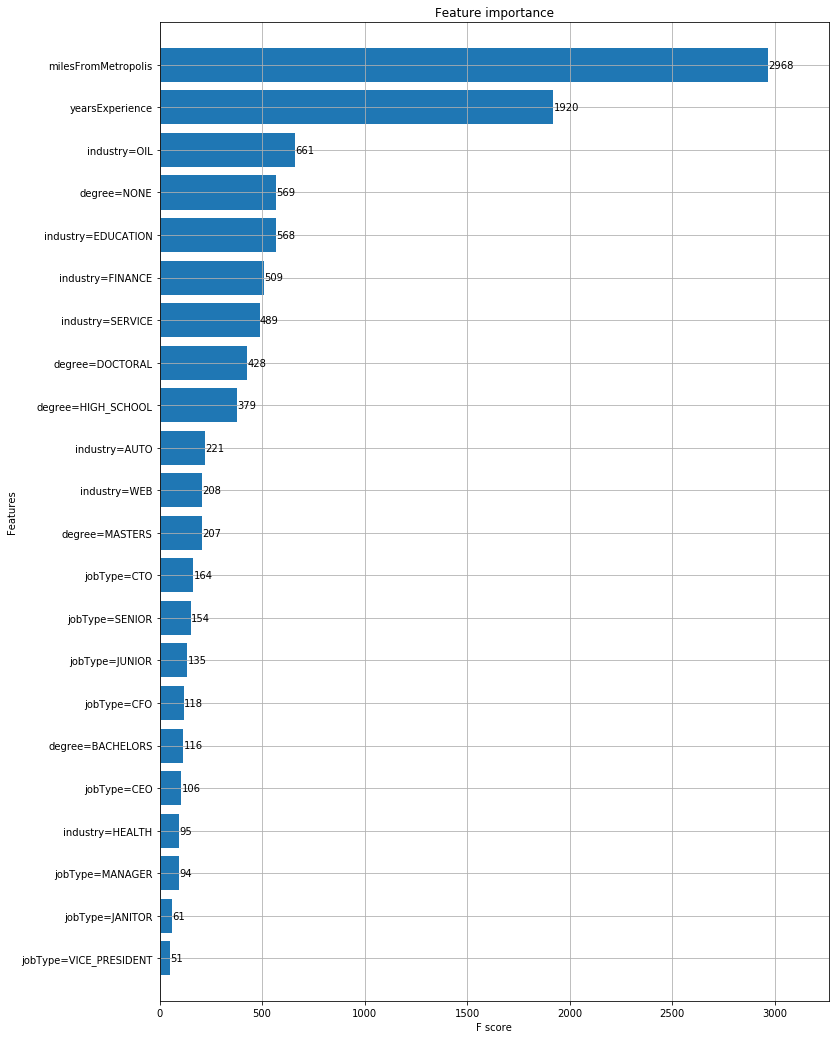

time used: 79.1447913646698


In [43]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
#section 5: final selected model
plot_feature_importance(regr,cols)
'''
Results:
    Accuracy: 0.74 (+/- 0.00)
    Root Mean squared error of training: 18.14
    Variance score: 0.78
    Root Mean squared error of blind prediction: 19.80
    Variance score: 0.74
'''

In [ ]:
#section 6: predict 
df_test=pd.read_csv('test_features.csv')
X,cols=preprocess_data(df_test[selected_cols])
y_predict=regr.predict(X)

out=df_test[['jobId']]
out['salary']=y_predict
out.to_csv('test_salaries.csv',index=False)

array(['degree=BACHELORS', 'degree=DOCTORAL', 'degree=HIGH_SCHOOL',
       'degree=MASTERS', 'degree=NONE', 'industry=AUTO',
       'industry=EDUCATION', 'industry=FINANCE', 'industry=HEALTH',
       'industry=OIL', 'industry=SERVICE', 'industry=WEB', 'jobType=CEO',
       'jobType=CFO', 'jobType=CTO', 'jobType=JANITOR', 'jobType=JUNIOR',
       'jobType=MANAGER', 'jobType=SENIOR', 'jobType=VICE_PRESIDENT',
       'milesFromMetropolis', 'yearsExperience'], dtype='<U22')